# TASK:
# For each image, determine what is on the image (choose one class out of 1000 possible options associated with ImageNet database)

(run each cell one after the other, it is specifically stated where the changes are required)

In [1]:
# importing all the libraries that we will need
import matplotlib.pyplot as plt
import numpy as np
import logging
import math

import torch
from torchvision import datasets, transforms, models
from torchsummary import summary

# Mounting Drive, setting up directory

In [2]:
# mounting the drive, so that we can use image folders etc. (this is a standard step when using colab and importing your own data)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# set up directories to use later, change both based on your system. 
# (If you put the "ImageNet_classification_DEMO" directly to your home folder on the Google Drive, your path will probably be
# '/content/drive/My Drive/ImageNet_classification_DEMO/test_data/')

notebook_dir = '/content/drive/My Drive/High_School_Demos/ImageNet_classification_DEMO/' # where this notebook is
data_dir = '/content/drive/My Drive/High_School_Demos/ImageNet_classification_DEMO/test_data/' # where our images are

# Loading ImageNet classes

In [20]:
# let's load the list of all the classes (e.g. cat, dog, car, tree, airplane,...) that the model that we will use can recognise.
# In total there are 1000 of such classes (called labels) that are accessible in the link below (the original list) and are also present in the notebook folder (shortened list)
# https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a#file-imagenet1000_clsidx_to_labels-txt

with open(notebook_dir+"ImageNet_labels.txt") as f:
    idx2label = eval(f.read())

# Loading pre-trained model

In [23]:
# let's pick a model out of the repository. 'pretrained' shoud be set to True, because we want a model that someone already trained on a ton of data
# (i.e. a model that already knows how to do its task and doesn't need to be trained). This way we can use this model without having to do any additional work.

# if you want to play with it, you can try loading various different models, here is the repository:
# https://pytorch.org/docs/stable/torchvision/models.html

model = models.resnet18(pretrained=True)

for param in model.parameters(): # freezing the parameters of the model, because we are using it as is without additional changes
    param.requires_grad = False

In [6]:
# let's print the architecture of the model (mostly pay attention to the number of parameters at the bottom to give you the idea of the computational size)
# note that the summary function can be a bit buggy (there is a bug if you use it with densenet instead of resnet), so don't worry if it doesn't work for some architectures

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

# Setting up the Data

In [7]:
# define the transformations of the images, according to the requirements of the model (this is known from literature):

test_transforms = transforms.Compose([transforms.Resize(255),                      # first resize the images to a smaller size 
                                      transforms.CenterCrop(224),                  # crop them to the final size that is required for the model 3*224*224 = 3 RGB channels, height, width = 224
                                      transforms.ToTensor(),                       # change format
                                      transforms.Normalize([0.485, 0.456, 0.406],  # change colours and contrasts
                                                           [0.229, 0.224, 0.225])])

# create the dataloader for later use:

test_data_orig = datasets.ImageFolder(data_dir + 'base', transform=None)          # original images without any transformation       
test_data = datasets.ImageFolder(data_dir + 'base', transform=test_transforms)    # transformed images prepared to be the model input
num_samples = len(test_data_orig)
testloader = torch.utils.data.DataLoader(test_data, batch_size=num_samples)

In [8]:
# helper functions to plot the original data and the transformed data (separate functions for practical reasons), see their use below:

def plot_original_images(total_samples, images, image_labels=None, predicted_labels=False):
  fig = plt.figure(figsize=(5*5, (math.ceil(total_samples/5))*5))
  for idx in np.arange(total_samples):
      ax = fig.add_subplot(math.ceil(total_samples/5), 5, idx+1)
      plt.imshow(images[idx][0])
      if predicted_labels:
        ax.set_title(image_labels[idx], fontsize=18)
  plt.tight_layout()
  plt.show()

def plot_transformed_images(total_samples, image_loader):
  dataiter = iter(image_loader)
  images, _ = dataiter.next()
  images = images.numpy()

  logger = logging.getLogger() # supress clipping warning using logging (not important)
  old_level = logger.level
  logger.setLevel(100)

  fig = plt.figure(figsize=(5*5, (math.ceil(total_samples/5))*5))
  for idx in np.arange(total_samples):
      ax = fig.add_subplot(math.ceil(total_samples/5), 5, idx+1)
      img = np.moveaxis(images[idx], 0, -1)
      plt.imshow(img)
  plt.tight_layout()
  plt.show()

  logger.setLevel(old_level)

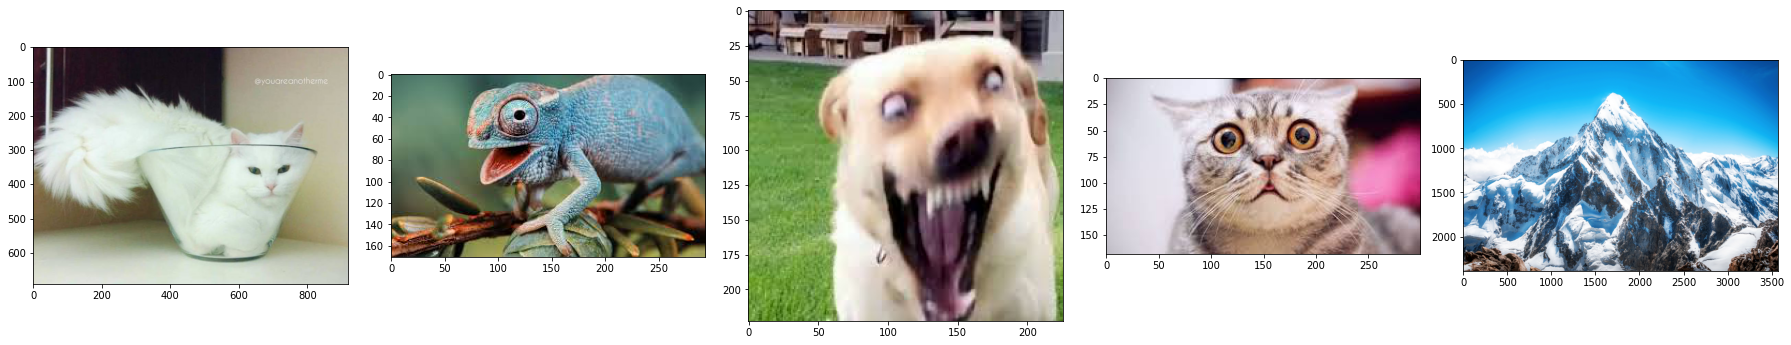

In [9]:
# let's first plot the sample images as they are. You can see that they have different sizes, different aspect ratios, and different quality

plot_original_images(num_samples, test_data_orig, image_labels=None, predicted_labels=False)

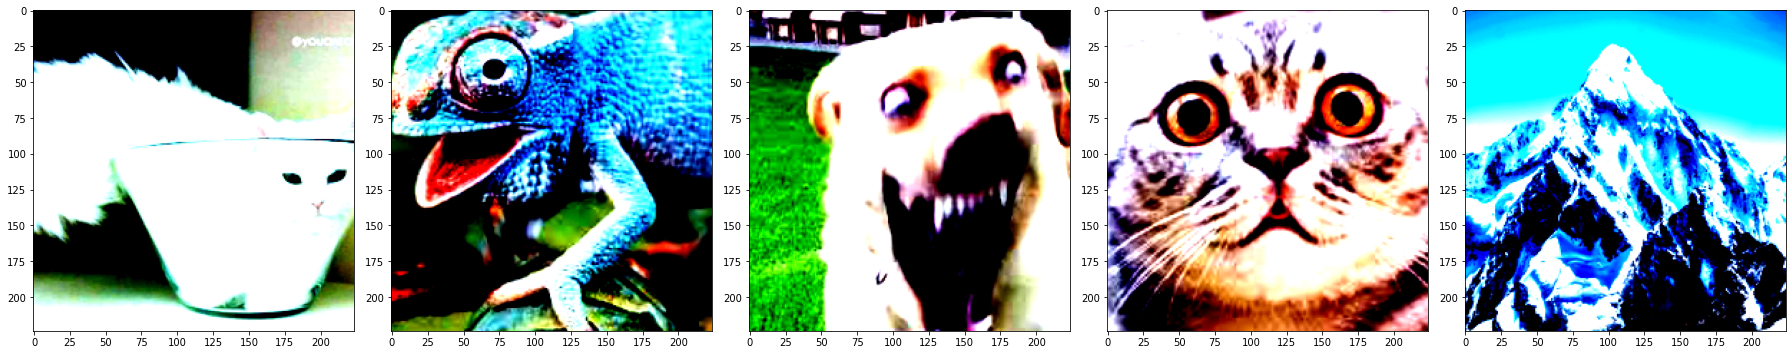

In [10]:
# let's now see how the input for the model looks like (the transformed images) - they are smaller, all the same size, square, and with adjusted colours

plot_transformed_images(num_samples, testloader)

# PREDICTING = WHAT DOES THE IMAGE REPRESENT?  (out or 1000 options)

In [11]:
model.eval()
for images, labels in testloader:     # load the transformed images
    output = model.forward(images)    # predict the output of the image using the model from above

# the result for each image is a 1000-unit long list of values - we need to find the index of the largest value, because this indicates the most probable prediction
result_idx = output.argmax(axis=1).numpy()  

# here is the index of the prediction for each of the 6 test images that we used
print(result_idx)

[283  47 208 281 970]


In [12]:
# the above numbers have to be finally converted to actual text using the list of ImageNet classes that we loaded at the beginning. 
# In this list each index between 0 and 999 corresponds to a label

result_label = [idx2label[out] for out in result_idx]

# in our case indexes [283 333  47 208 281 970] corresponds to the following labels
print(result_label)

['Persian cat', 'African chameleon, Chamaeleo chamaeleon', 'Labrador retriever', 'tabby, tabby cat', 'alp']


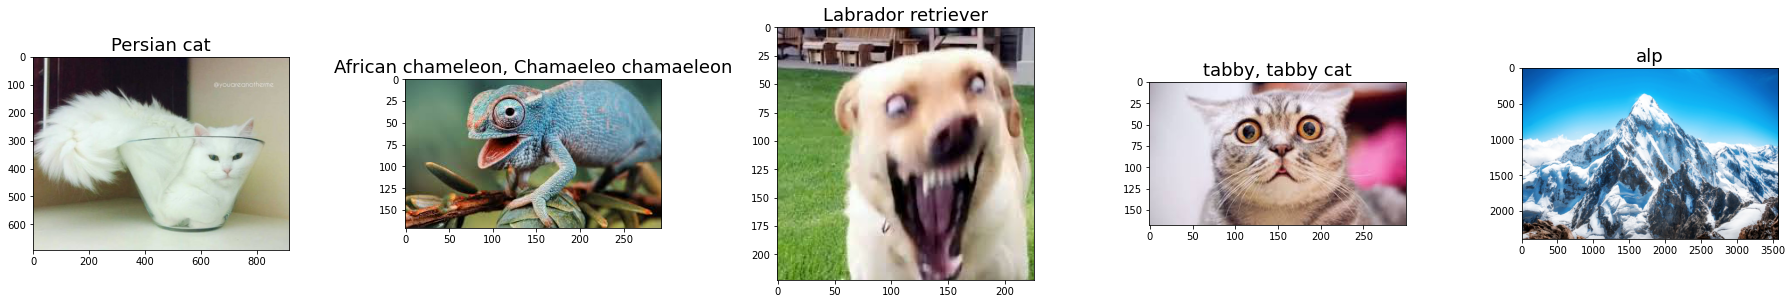

In [13]:
# let's now plot it again with added labels that we just calculated:

plot_original_images(num_samples, test_data_orig, image_labels=result_label, predicted_labels=True)

# PLAY WITH YOUR OWN IMAGES

## Load whatever images that you want to the folder 'student_images' and repeat the steps from above:

In [27]:
# let's reload the model

model = models.resnet18(pretrained=True)

for param in model.parameters(): # freezing the parameters of the model, because we are using it as is without additional changes
    param.requires_grad = False

In [24]:
#prepare the data loader (_ST refers to the students' images)

test_data_orig_ST = datasets.ImageFolder(data_dir + 'student_images', transform=None)
test_data_ST = datasets.ImageFolder(data_dir + 'student_images', transform=test_transforms)

num_samples_ST = len(test_data_orig_ST)

testloader_ST = torch.utils.data.DataLoader(test_data_ST, batch_size=num_samples_ST)
testloader_orig_ST = torch.utils.data.DataLoader(test_data_orig_ST, batch_size=num_samples_ST)

In [25]:
# calculate predictions

model.eval()
for images, labels in testloader_ST:
    output_ST = model.forward(images)

result_idx_ST = output_ST.argmax(axis=1).numpy()
result_label_ST = [idx2label[out] for out in result_idx_ST]

In [26]:
# plot the data together with the predicted labels
# try to think why some of the labels could be predicted wrong

plot_original_images(num_samples_ST, test_data_orig_ST, image_labels=result_label_ST, predicted_labels=True)

Output hidden; open in https://colab.research.google.com to view.

## If wou want to investigate further, it is informative to look at the examples where the prediction was not correct. Sometime it is expected because the image might be ambiguous or there is no such class in ImageNet collection. Sometimes the model makes an understandable mistake (mistakens an object for a very similar object). 
## It is often interesting to see not only what is the first prediction (this is what we focused on above), but what is the second or third choice of the model:

In [58]:
img_idx = 2 # pick the index of image of interest from above (note that indexes start with 0, so image under e.g. index 2 is the sock)

# let's print the top three predictions for this image (descending order)
temp = np.argsort(output_ST[img_idx].numpy(), axis=-1, kind='quicksort')
print ('First prediction: \t{} \nSecond prediction: \t{} \nThird prediction: \t{}'.format(idx2label[temp[-1]], idx2label[temp[-2]], idx2label[temp[-3]]))

First prediction: 	stingray 
Second prediction: 	wool, woolen, woollen 
Third prediction: 	doormat, welcome mat
